## Mask Adherence: AIF 360 Demo
Reducing ethnicity bias in synthetic 'Mask Adherence' dataset using [AIF360](https://github.com/Trusted-AI/AIF360).

## Table of Contents
1. <a href='#goal'>Problem Statement</a>
2. <a href='#data'>Data Collection</a>
3. <a href='#bias1'>Investigating Bias</a>
4. <a href='#model1'>Initial Model</a>
5. <a href='#bias2'>Bias Mitigation</a>
6. <a href='#model1'>Retraining</a>

In [1]:
# Display settings
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")
# Data Analysis 
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
# Visulaization 
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
sns.set_context('talk')
# Model developemnt 
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Bias mitigation 
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing

<a id='goal'></a>
## 1. Problem Statement
**Objective**: Demonstrate AIF360 as a tool to identify and remediate bias.

**Scenario**: User is a machine learning researcher creating a model to predict adherence to mask guidelines.

**Background**: According to studies, rates of mask adherence differ by ethnicity. Individuals from communities of color have reported higher rates of mask-wearing. [One study](https://www.theday.com/article/20200515/OP03/200519635) found that 82% of Asian Americans, 74% of African Americans, and 71% of Latinos said they had been wearing a mask outside the home, while only 66% of whites said the same.

**Challenge**: The researcher suspects that in this (synthetic) training dataset, Asian Americans are over-represented as mask-wearing. 

**Approach**: Deploying the AIF360 toolkit, the researcher can
1. Identify target metrics by class
2. Reweight dataset
3. Retrain model on reweighted dataset

<a id='data'></a>
## 2. Data Collection
**Dataset**: 'Mask Adherence' synthetic data created by Atlas Research from 7200 records based on '[Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult)' (i.e. the Census Income dataset) from UCI Machine Learning Repository. The Adult Dataset contains 48,842 entries extracted from the 1994 US Census database.

In [2]:
data = pd.read_csv('../data/mask.csv', index_col='id')

In [3]:
data

,dataset,age,work,education,education_num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,mask
id,,,,,,,,,,,,,,
0,train,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,1
1,train,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,1
2,train,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,train,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,train,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34756,test,45,Private,Bachelors,13,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,1
34757,test,25,Private,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,25,0
34758,test,47,Self-emp-inc,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,1


<a id='eda'></a>
### 2.1 Exploratory Data Analysis

**Features**:
- *age*: the age of an individual (int 17 to 90)
- *workclass*: a general term to represent employment status (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked)
- *education­num*: the highest level of education achieved in numerical form (int greater than 0 where 1 :  Preschool, 2 :  1st-4th, 3 :  5th-6th, 4 :  7th-8th, 5 :  9th, 6 :  10th, 7 :  11th, 8 :  12th, 9 :  HS-grad, 10 :  Some-college, 11 :  Assoc-voc, 12 :  Assoc-acdm, 13 :  Bachelors, 14 :  Masters, 15 :  Prof-school, 16 :  Doctorate)
- *marital­status*: marital status of an individual. Married­civ­spouse corresponds to a civilian spouse while Married­AF­spouse is a spouse in the Armed Forces. (Married­civ­spouse, Divorced, Never­married, Separated, Widowed, Married­spouse­absent, Married­AF­spouse)
- *occupation*: the general type of occupation of an individual (Tech­support, Craft­repair, Other­service, Sales, Exec­managerial, Prof­specialty, Handlers­cleaners, Machine­op­inspct, Adm­clerical, Farming­fishing, Transport­moving, Priv­house­serv, Protective­serv, Armed­Forces)
- *relationship*: represents what this individual is relative to others. For example an individual could be a Husband. Each entry only has one relationship attribute and is somewhat redundant with marital status. (Wife, Own­child, Husband, Not­in­family, Other­relative, Unmarried)
- *race*: Descriptions of an individual’s race (White, Hispanic, Black, Asian, Other)
- *sex*: the biological sex of the individual (Male, Female)
- *capital­gain*: capital gains for an individual (int >= 0)
- *capital­loss*: capital loss for an individual (int >= 0)
- *hours­per­week*: the hours an individual has reported to work per week (continuous)
- *mask*: adherence to mask-wearing guidance (boolean)

In [4]:
data.describe(include='all')

,dataset,age,work,education,education_num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,mask
count,7200,"7,200.00",7200,7200,"7,200.00",7200,7200,7200,7200,7200,"7,200.00","7,200.00","7,200.00","7,200.00"
unique,2,nan,8,16,nan,7,15,6,5,2,nan,nan,nan,nan
top,train,nan,Private,HS-grad,nan,Married-civ-spouse,Prof-specialty,Husband,White,Male,nan,nan,nan,nan
freq,5000,nan,4916,2315,nan,3281,921,2890,4365,4846,nan,nan,nan,nan
mean,NaN,38.61,NaN,NaN,10.07,NaN,NaN,NaN,NaN,NaN,"1,127.78",91.62,40.49,0.70
std,NaN,13.64,NaN,NaN,2.58,NaN,NaN,NaN,NaN,NaN,"7,640.71",408.35,12.15,0.46
min,NaN,17.00,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,1.00,0.00
25%,NaN,28.00,NaN,NaN,9.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,40.00,0.00
50%,NaN,37.00,NaN,NaN,10.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,40.00,1.00
75%,NaN,48.00,NaN,NaN,12.25,NaN,NaN,NaN,NaN,NaN,0.00,0.00,45.00,1.00


### 2.2 Target Analysis

In [5]:
pd.DataFrame(data.groupby('race')['mask'].value_counts(normalize=True)).rename({'mask':'perc'}, axis=1)

perc
race     mask      
Asian    1     0.91
         0     0.09
Black    1     0.75
         0     0.25
Hispanic 1     0.73
         0     0.27
Other    1     0.52
         0     0.48
White    1     0.67
         0     0.33

### 2.3 Preprocessing

In [6]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

num_cols = data.describe().columns
all_cols = data.describe(include='all').columns
cat_cols = Diff(all_cols, num_cols)
cat_cols

['work',
 'race',
 'relationship',
 'education',
 'marital-status',
 'dataset',
 'occupation',
 'sex']

In [7]:
#Deep copy the original data
data_encoded = data.copy(deep=True)
#Use Scikit-learn label encoding to encode character data
lab_enc = preprocessing.LabelEncoder()
for col in cat_cols:
        data_encoded[col] = lab_enc.fit_transform(data[col])
        le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
        print('Feature:', col)
        print('  Mapping:', le_name_mapping)

Feature: work
  Mapping: {' ?': 0, ' Federal-gov': 1, ' Local-gov': 2, ' Private': 3, ' Self-emp-inc': 4, ' Self-emp-not-inc': 5, ' State-gov': 6, ' Without-pay': 7}
Feature: race
  Mapping: {'Asian': 0, 'Black': 1, 'Hispanic': 2, 'Other': 3, 'White': 4}
Feature: relationship
  Mapping: {' Husband': 0, ' Not-in-family': 1, ' Other-relative': 2, ' Own-child': 3, ' Unmarried': 4, ' Wife': 5}
Feature: education
  Mapping: {' 10th': 0, ' 11th': 1, ' 12th': 2, ' 1st-4th': 3, ' 5th-6th': 4, ' 7th-8th': 5, ' 9th': 6, ' Assoc-acdm': 7, ' Assoc-voc': 8, ' Bachelors': 9, ' Doctorate': 10, ' HS-grad': 11, ' Masters': 12, ' Preschool': 13, ' Prof-school': 14, ' Some-college': 15}
Feature: marital-status
  Mapping: {' Divorced': 0, ' Married-AF-spouse': 1, ' Married-civ-spouse': 2, ' Married-spouse-absent': 3, ' Never-married': 4, ' Separated': 5, ' Widowed': 6}
Feature: dataset
  Mapping: {'test': 0, 'train': 1}
Feature: occupation
  Mapping: {' ?': 0, ' Adm-clerical': 1, ' Armed-Forces': 2, ' Cra

<a id='bias1'></a>
## 3. Investigating Bias
The AI Fairness 360 toolkit is an open-source library to help detect and remove bias in machine learning models. The AI Fairness 360 Python package includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models.  Converts dataset into a format that can be used by bias mitigation algorithms

- Github: https://github.com/IBM/AIF360
- Website: http://aif360.mybluemix.net/

**Objective**: Assess bias present in race feature in training dataset.


**Approach**: Identify the following in the dataset
- Favorable label
- Unfavorable label
- Privileged group 
- Unprivileged group

**Mapping**: {'Asian': 0, 'Black': 1, 'Hispanic': 2, 'Other': 3, 'White': 4}


In [8]:
data_encoded['POC'] = data_encoded['race'].apply(lambda x: 1 if x == 0 else (2 if (x == 1 or x == 2) else 0))
data_encoded[['race', 'POC']].head(20)

,race,POC
id,,
0,4,0
1,4,0
2,4,0
3,1,2
4,1,2
5,4,0
6,1,2
7,4,0
8,4,0


In [9]:
privileged_groups = [{'POC': 1}]
unprivileged_groups = [{'POC': 2}]
favorable_label = 1 
unfavorable_label = 0

In [10]:
data_encoded

,dataset,age,work,education,education_num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,mask,POC
id,,,,,,,,,,,,,,,
0,1,39,6,9,13,4,1,1,4,1,2174,0,40,1,0
1,1,50,5,9,13,2,4,0,4,1,0,0,13,1,0
2,1,38,3,11,9,0,6,1,4,1,0,0,40,0,0
3,1,53,3,1,7,2,6,0,1,1,0,0,40,0,2
4,1,28,3,9,13,2,10,5,1,0,0,0,40,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34756,0,45,3,9,13,2,8,0,4,1,0,0,40,1,0
34757,0,25,3,15,10,4,1,3,4,0,0,0,25,0,0
34758,0,47,4,15,10,2,12,0,4,1,0,0,45,1,0


In [11]:
training_data = data_encoded[data_encoded['dataset'] == 1]
test_data = data_encoded[data_encoded['dataset'] == 0]

In [12]:
BM_dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label,
                                df=training_data,
                                label_names=['mask'],
                                protected_attribute_names=['POC'],
                                unprivileged_protected_attributes=unprivileged_groups)

In [13]:
display(Markdown("#### Training Data Details"))
print("- Shape of the training dataset:", BM_dataset.features.shape)
print("- Training data favorable label:", BM_dataset.favorable_label)
print("- Training data unfavorable label:", BM_dataset.unfavorable_label)
print("- Training data protected attribute:", BM_dataset.protected_attribute_names)

#### Training Data Details

- Shape of the training dataset: (5000, 14)
- Training data favorable label: 1.0
- Training data unfavorable label: 0.0
- Training data protected attribute: ['POC']


In [14]:
metric_orig_train = BinaryLabelDatasetMetric(BM_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.168544


<a id='model1'></a>
## 4. Initial Model

In [15]:
sns.set_context('talk')
X_train = training_data.drop('mask', axis=1)
y_train = training_data['mask']
X_test = test_data.drop('mask', axis=1)
y_test = test_data['mask']

In [16]:
clf=RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [17]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7068181818181818


### 4.0 All classes

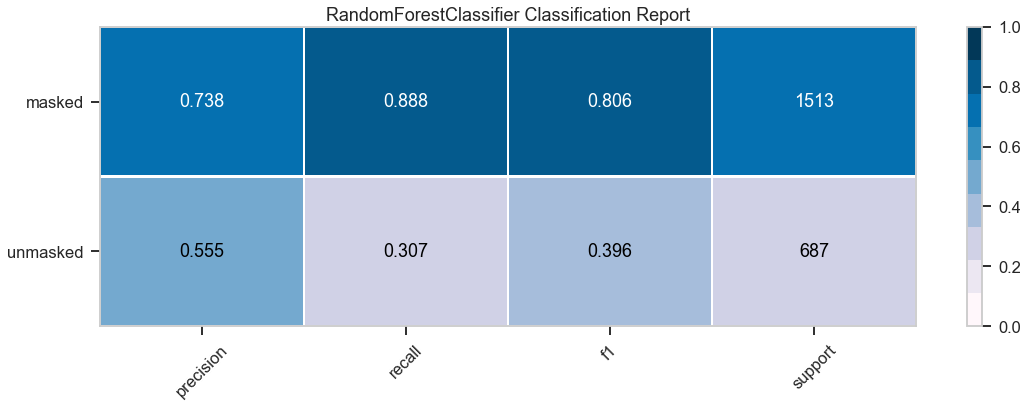

In [18]:
plt.figure(figsize=(16,6))
visualizer = ClassificationReport(clf, classes = ['unmasked', 'masked'], support=True, cmap='PuBu')
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();   

### 4.1 Asian only

In [19]:
X0 = test_data[test_data['POC'] == 1].drop('mask', axis=1)
y0 = test_data[test_data['POC'] == 1]['mask']

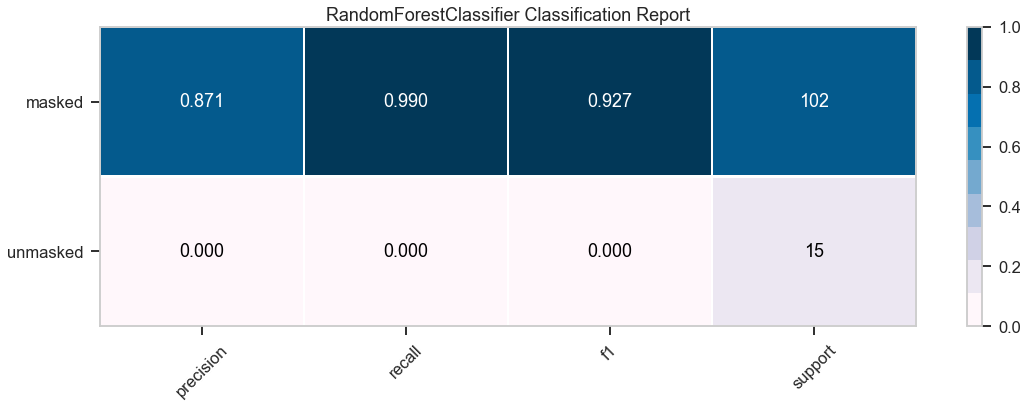

In [20]:
plt.figure(figsize=(16,6))
visualizer = ClassificationReport(clf, classes = ['unmasked', 'masked'], support=True, cmap='PuBu')
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X0, y0)                # Evaluate the model on the test data
visualizer.show();   

<a id='bias2'></a>
## 5. Bias Mitigation

In [21]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(BM_dataset)
train_tf_dataset = RW.transform(BM_dataset)

In [22]:
metric_orig_train = BinaryLabelDatasetMetric(train_tf_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f"
      % metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


<a id='model2'></a>
## 6. Retraining 

In [23]:
df, ft_dict = train_tf_dataset.convert_to_dataframe()
weights = ft_dict.get('instance_weights')

In [24]:
X_train = df.drop('mask', axis=1)
y_train = df['mask']

In [25]:
clf=RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train,y_train,sample_weight=weights)
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7077272727272728


### 6.0 All classes

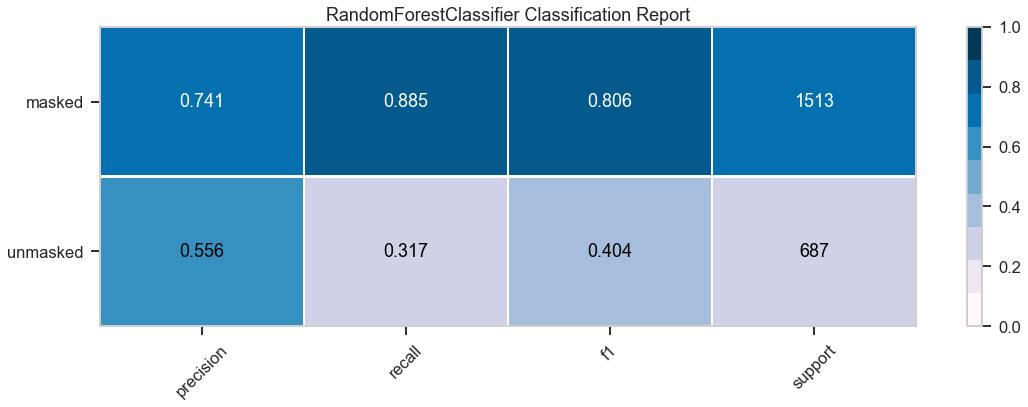

In [26]:
plt.figure(figsize=(16,6))
visualizer = ClassificationReport(clf, classes = ['unmasked', 'masked'], support=True, cmap='PuBu')
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();   

### 6.1 Asian only

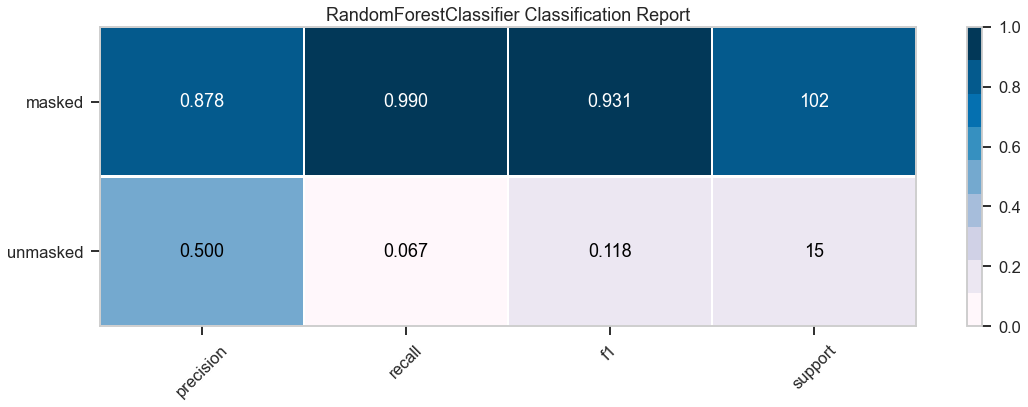

In [27]:
plt.figure(figsize=(16,6))
visualizer = ClassificationReport(clf, classes = ['unmasked', 'masked'], support=True, cmap='PuBu')
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X0, y0)                # Evaluate the model on the test data
visualizer.show();   